# Enhanced Music Similarity Model
## Intelligent Music Recommendation System

This notebook builds a comprehensive music similarity system using:
- **Multi-modal features**: Audio embeddings, acoustic features, and metadata
- **Hybrid similarity**: Combines deep learning embeddings with hand-crafted features
- **Explainable recommendations**: Shows why songs are similar
- **Mood-based filtering**: Activity and emotion-aware recommendations

---

## Part 1: Setup and Configuration

In [12]:
# Install required packages
!pip install --break-system-packages -q librosa transformers torch faiss-cpu pandas numpy scikit-learn tqdm

In [13]:
# Core imports
import os
import sys
import json
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data handling
import pandas as pd
import numpy as np
from tqdm import tqdm

# Audio processing
import librosa
import librosa.display

# Machine learning
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import faiss

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✓ All imports successful")

✓ All imports successful


In [14]:
#file paths
class Config:
    # Base directories
    project_root = Path.cwd()
    data_dir = project_root / "data"
    
    # Raw data
    fma_audio = data_dir / "raw" / "fma" / "fma_small"
    fma_metadata = data_dir / "raw" / "fma" / "fma_metadata"
    
    # Processed data
    processed_dir = data_dir / "processed"
    ab_parquet = processed_dir / "ab_fma_filtered.parquet"
    manifest_path = processed_dir / "mini_manifest.parquet"
    
    # Embeddings
    emb_dir = data_dir / "embeddings"
    
    # Model outputs
    models_dir = data_dir / "models"
    faiss_index = models_dir / "similarity.index"
    
    # Audio parameters
    sample_rate = 16000
    max_duration = 30  # seconds
    
    # Wav2Vec2 model
    model_name = "facebook/wav2vec2-base"
    embedding_dim = 768
    
    # Similarity parameters
    k_neighbors = 10  # Number of similar songs to retrieve
    
# Create necessary directories
for dir_path in [Config.processed_dir, Config.emb_dir, Config.models_dir]:
    dir_path.mkdir(parents=True, exist_ok=True)

print(f"✓ Configuration set")
print(f"  Project root: {Config.project_root}")
print(f"  FMA audio exists: {Config.fma_audio.exists()}")
print(f"  FMA metadata exists: {Config.fma_metadata.exists()}")

✓ Configuration set
  Project root: C:\Users\nakay\Documents\musicrec
  FMA audio exists: True
  FMA metadata exists: True


## Part 2: Data Loading and Preparation

In [15]:
# load and cleans large multi-index fma metadata csv
def load_fma_metadata():
    """Load and process FMA metadata."""
    print("Loading FMA metadata...")
    
    # Load tracks.csv with multi-index headers
    tracks_path = Config.fma_metadata / "tracks.csv"
    if not tracks_path.exists():
        # Try loading from zip
        import zipfile
        zip_path = Config.fma_metadata.with_suffix('.zip')
        if zip_path.exists():
            with zipfile.ZipFile(zip_path) as z:
                with z.open("fma_metadata/tracks.csv") as f:
                    tracks = pd.read_csv(f, header=[0,1,2], index_col=0)
        else:
            raise FileNotFoundError(f"Cannot find {tracks_path} or {zip_path}")
    else:
        tracks = pd.read_csv(tracks_path, header=[0,1,2], index_col=0)
    
    # Flatten multi-index columns
    flat_cols = ['__'.join([str(x) for x in tup if pd.notna(x) and str(x)!=''])
                 for tup in tracks.columns.to_flat_index()]
    import re
    clean_cols = [re.sub(r'__Unnamed:.*$', '', c) for c in flat_cols]
    tracks.columns = clean_cols
    
    # Create slim version with essential fields
    fma_slim = pd.DataFrame({
        "track_id": tracks.index.astype(int),
        "title": tracks.get("track__title", ""),
        "artist": tracks.get("artist__name", ""),
        "album": tracks.get("album__title", ""),
        "genre_top": tracks.get("track__genre_top", ""),
        "duration": tracks.get("track__duration", 0),
    })
    
    print(f"✓ Loaded {len(fma_slim)} FMA tracks")
    return fma_slim

fma_data = load_fma_metadata()
fma_data.head()

Loading FMA metadata...
✓ Loaded 106574 FMA tracks


,track_id,title,artist,album,genre_top,duration
2,2,Food,AWOL,AWOL - A Way Of Life,Hip-Hop,168
3,3,Electric Ave,AWOL,AWOL - A Way Of Life,Hip-Hop,237
5,5,This World,AWOL,AWOL - A Way Of Life,Hip-Hop,206
10,10,Freeway,Kurt Vile,Constant Hitmaker,Pop,161
20,20,Spiritual Level,Nicky Cook,Niris,NaN,311


In [16]:
def load_acousticbrainz_features():
    """Load AcousticBrainz features - with fallback for corrupted parquet."""
    print("Loading AcousticBrainz features...")
    
    if not Config.ab_parquet.exists():
        print("⚠ AcousticBrainz parquet not found. Creating empty dataframe.")
        print("  You'll need to regenerate this file from AcousticBrainz JSONs.")
        return pd.DataFrame(columns=[
            'track_id', 'bpm', 'key', 'mode', 'mood_acoustic', 
            'mood_aggressive', 'mood_happy', 'mood_sad', 
            'danceability', 'voice_instrumental'
        ])
    
    try:
        ab_features = pd.read_parquet(Config.ab_parquet)
        print(f"✓ Loaded {len(ab_features)} AcousticBrainz features")
        return ab_features
    except Exception as e:
        print(f"⚠ Error loading parquet: {e}")
        print("  Creating empty dataframe. You'll need to regenerate the file.")
        return pd.DataFrame(columns=[
            'track_id', 'bpm', 'key', 'mode', 'mood_acoustic',
            'mood_aggressive', 'mood_happy', 'mood_sad',
            'danceability', 'voice_instrumental'
        ])

ab_data = load_acousticbrainz_features()
ab_data.head()

Loading AcousticBrainz features...
✓ Loaded 709 AcousticBrainz features


,track_id,ab_artist,ab_title,ab_mbid,bpm,bpm_confidence,key_key,key_scale,key_strength,mood_acoustic,mood_aggressive,mood_happy,mood_sad,danceability,voice_instrumental,genre_dortmund,ab_path
0,534,Charles Manson,I Can See You,44d98503-e039-4472-9f81-5c81e9262314,144.266220,None,G#,minor,0.665570,None,None,None,None,None,None,None,data\raw\acousticbrainz\acousticbrainz-mediaev...
1,535,Charles Manson,Angels Fear to Tread,16ff3444-d4d5-43dc-8123-15a800862bc5,97.698425,None,B,major,0.649779,None,None,None,None,None,None,None,data\raw\acousticbrainz\acousticbrainz-mediaev...
2,540,Charles Manson,The Black Pirate,1641544e-64e2-4a86-baf1-de02c342277f,135.865082,None,G#,major,0.737001,None,None,None,None,None,None,None,data\raw\acousticbrainz\acousticbrainz-mediaev...
3,541,Charles Manson,So We Go Again,56b4d29d-a35d-46c2-a07a-3f068fdb1a99,105.680603,None,G#,minor,0.769404,None,None,None,None,None,None,None,data\raw\acousticbrainz\acousticbrainz-mediaev...
4,542,Charles Manson,Self Is Eternal (What Our World Will Be),4f4eaffa-99f4-4f72-92ac-e1cec2810565,139.959534,None,E,minor,0.412288,None,None,None,None,None,None,None,data\raw\acousticbrainz\acousticbrainz-mediaev...


In [17]:
#merge fma and acousitcBrainz features into one dataFrame
def create_master_dataset(fma_df, ab_df):
    #Merge FMA and AcousticBrainz data.
    print("Creating master dataset...")
    
    # Merge on track_id
    if len(ab_df) > 0:
        master = fma_df.merge(ab_df, on='track_id', how='left')
    else:
        master = fma_df.copy()
        # Add placeholder AB columns
        for col in ['bpm', 'key', 'mode', 'mood_acoustic', 'mood_aggressive',
                    'mood_happy', 'mood_sad', 'danceability', 'voice_instrumental']:
            master[col] = np.nan
    
    # Add audio file paths
    def get_audio_path(track_id):
        tid_str = f"{int(track_id):06d}"
        folder = tid_str[:3]
        return Config.fma_audio / folder / f"{tid_str}.mp3"
    
    master['audio_path'] = master['track_id'].apply(get_audio_path)
    master['audio_exists'] = master['audio_path'].apply(lambda p: p.exists())
    
    # Filter to existing audio files only
    master = master[master['audio_exists']].copy()
    
    print(f"✓ Master dataset created with {len(master)} tracks")
    print(f"  Tracks with audio: {master['audio_exists'].sum()}")
    
    return master

master_data = create_master_dataset(fma_data, ab_data)
master_data.head()

Creating master dataset...
✓ Master dataset created with 8000 tracks
  Tracks with audio: 8000


,track_id,title,artist,album,genre_top,duration,ab_artist,ab_title,ab_mbid,bpm,...,mood_acoustic,mood_aggressive,mood_happy,mood_sad,danceability,voice_instrumental,genre_dortmund,ab_path,audio_path,audio_exists
0,2,Food,AWOL,AWOL - A Way Of Life,Hip-Hop,168,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:\Users\nakay\Documents\musicrec\data\raw\fma...,True
2,5,This World,AWOL,AWOL - A Way Of Life,Hip-Hop,206,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:\Users\nakay\Documents\musicrec\data\raw\fma...,True
3,10,Freeway,Kurt Vile,Constant Hitmaker,Pop,161,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:\Users\nakay\Documents\musicrec\data\raw\fma...,True
15,140,Queen Of The Wires,Alec K. Redfearn & the Eyesores,The Blind Spot,Folk,253,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:\Users\nakay\Documents\musicrec\data\raw\fma...,True
16,141,Ohio,Alec K. Redfearn & the Eyesores,Every Man For Himself,Folk,182,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C:\Users\nakay\Documents\musicrec\data\raw\fma...,True


## Part 3: Feature Extraction System

In [18]:
#extract audio features using librosa
class AudioFeatureExtractor:
    """Extract comprehensive audio features using Librosa."""
    
    def __init__(self, sr=Config.sample_rate, duration=Config.max_duration):
        self.sr = sr
        self.duration = duration
    
    def extract_features(self, audio_path):
        """Extract all audio features from a file."""
        try:
            # Load audio
            y, sr = librosa.load(audio_path, sr=self.sr, duration=self.duration, mono=True)
            
            if len(y) == 0:
                return None
            
            features = {}
            
            # Tempo and beat
            tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
            features['tempo'] = float(tempo)
            features['beat_strength'] = float(np.mean(librosa.onset.onset_strength(y=y, sr=sr)))
            
            # Spectral features
            spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
            features['spectral_centroid_mean'] = float(np.mean(spectral_centroids))
            features['spectral_centroid_std'] = float(np.std(spectral_centroids))
            
            spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
            features['spectral_rolloff_mean'] = float(np.mean(spectral_rolloff))
            
            # Zero crossing rate (indicator of noisiness)
            zcr = librosa.feature.zero_crossing_rate(y)[0]
            features['zcr_mean'] = float(np.mean(zcr))
            
            # RMS energy
            rms = librosa.feature.rms(y=y)[0]
            features['rms_mean'] = float(np.mean(rms))
            features['rms_std'] = float(np.std(rms))
            
            # Chroma features (pitch class profiles)
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            features['chroma_mean'] = float(np.mean(chroma))
            features['chroma_std'] = float(np.std(chroma))
            
            # MFCCs (timbre)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            for i in range(13):
                features[f'mfcc{i+1}_mean'] = float(np.mean(mfccs[i]))
                features[f'mfcc{i+1}_std'] = float(np.std(mfccs[i]))
            
            return features
            
        except Exception as e:
            print(f"Error extracting features from {audio_path}: {e}")
            return None

print("✓ AudioFeatureExtractor defined")

✓ AudioFeatureExtractor defined


## TEST feature extraction

In [19]:
'''Test feature extraction on a sample'''
extractor = AudioFeatureExtractor()

sample_track = master_data[master_data['audio_exists']].iloc[0]
print(f"Testing on: {sample_track['artist']} - {sample_track['title']}")

sample_features = extractor.extract_features(sample_track['audio_path'])
if sample_features:
    print(f"\n✓ Extracted {len(sample_features)} features:")
    for key, value in list(sample_features.items())[:10]:
        print(f"  {key}: {value:.4f}")
    print("  ...")

Testing on: AWOL - Food

✓ Extracted 36 features:
  tempo: 170.4545
  beat_strength: 1.9260
  spectral_centroid_mean: 2354.6298
  spectral_centroid_std: 630.3001
  spectral_rolloff_mean: 4822.9472
  zcr_mean: 0.1825
  rms_mean: 0.1459
  rms_std: 0.0737
  chroma_mean: 0.4021
  chroma_std: 0.2918
  ...


In [20]:
# loops through tracks extract featrures and createing a clean dataFrame
def extract_features_batch(df, extractor, batch_size=100):
    """Extract features for a batch of tracks."""
    print(f"Extracting features for {len(df)} tracks...")
    
    features_list = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
        features = extractor.extract_features(row['audio_path'])
        
        if features:
            features['track_id'] = row['track_id']
            features_list.append(features)
    
    features_df = pd.DataFrame(features_list)
    print(f"✓ Extracted features for {len(features_df)} tracks")
    
    return features_df

# Extract features for a subset (adjust size as needed)
# Process more tracks for better accuracy
subset_size = min(1000, len(master_data))  # 1000 tracks for better accuracy
subset_df = master_data.head(subset_size)

audio_features = extract_features_batch(subset_df, extractor)
audio_features.head()

Extracting features for 1000 tracks...


Extracting features: 100%|█████████████████████████████████████████████████████████| 1000/1000 [05:44<00:00,  2.90it/s]

✓ Extracted features for 1000 tracks


,tempo,beat_strength,spectral_centroid_mean,spectral_centroid_std,spectral_rolloff_mean,zcr_mean,rms_mean,rms_std,chroma_mean,chroma_std,...,mfcc9_std,mfcc10_mean,mfcc10_std,mfcc11_mean,mfcc11_std,mfcc12_mean,mfcc12_std,mfcc13_mean,mfcc13_std,track_id
0,170.454545,1.925990,2354.629832,630.300053,4822.947239,0.182492,0.145925,0.073677,0.402139,0.291772,...,9.299210,-3.249961,10.104882,-3.417745,10.507483,4.844634,8.840707,1.919067,7.584236,2
1,98.684211,1.899034,1945.923029,615.376904,4422.216485,0.117084,0.151013,0.076153,0.414392,0.298308,...,10.392683,5.232149,10.428396,2.485339,8.189746,9.271208,9.122598,1.124954,7.198156,5
2,110.294118,1.143564,2107.306157,244.396986,3890.783418,0.195241,0.188846,0.040280,0.394538,0.269721,...,7.238335,-2.806131,6.594348,-4.966722,5.966090,0.109710,5.703552,-3.346016,5.552002,10
3,72.115385,1.653243,1217.354366,697.860441,2669.315301,0.048204,0.069522,0.037090,0.254506,0.302638,...,11.851746,0.636539,9.542922,-7.604945,8.138066,-0.763091,8.045051,-3.563854,7.622605,140
4,104.166667,1.305926,1344.834107,575.041747,2805.704709,0.077541,0.101533,0.077650,0.244114,0.297839,...,8.465611,-1.226460,8.748259,-7.171430,9.141627,-1.812176,7.870792,-0.756464,8.248363,141


## Part 4: Deep Learning Embeddings

In [21]:
class Wav2VecEmbedder:
    """Generate audio embeddings using Wav2Vec2."""
    
    def __init__(self, model_name=Config.model_name, device=None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Loading Wav2Vec2 model on {self.device}...")
        
        self.processor = Wav2Vec2Processor.from_pretrained(model_name)
        self.model = Wav2Vec2Model.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()
        
        print("✓ Model loaded")
    
    @torch.no_grad()
    def embed(self, audio_path):
        """Generate embedding for an audio file."""
        try:
            # Load audio
            y, sr = librosa.load(audio_path, sr=Config.sample_rate, 
                                duration=Config.max_duration, mono=True)
            
            if len(y) == 0:
                return None
            
            # Process audio
            inputs = self.processor(y, sampling_rate=Config.sample_rate, 
                                   return_tensors="pt", padding=False)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            
            # Get embeddings
            outputs = self.model(**inputs)
            
            # Pool embeddings (mean over time)
            embedding = outputs.last_hidden_state.mean(dim=1).squeeze(0)
            embedding = embedding.cpu().numpy().astype('float32')
            
            # Normalize
            embedding = embedding / np.linalg.norm(embedding)
            
            return embedding
            
        except Exception as e:
            print(f"Error embedding {audio_path}: {e}")
            return None

# Initialize embedder
embedder = Wav2VecEmbedder()

Loading Wav2Vec2 model on cpu...
✓ Model loaded


In [22]:
def generate_embeddings_batch(df, embedder, save_dir=None):
    """Generate embeddings for a batch of tracks."""
    print(f"Generating embeddings for {len(df)} tracks...")
    
    if save_dir:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
    
    embeddings = []
    track_ids = []
    
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating embeddings"):
        emb = embedder.embed(row['audio_path'])
        
        if emb is not None:
            embeddings.append(emb)
            track_ids.append(row['track_id'])
            
            # Optionally save individual embeddings
            if save_dir:
                np.save(save_dir / f"{row['track_id']}.npy", emb)
    
    embeddings_array = np.array(embeddings, dtype='float32')
    print(f"✓ Generated {len(embeddings_array)} embeddings with shape {embeddings_array.shape}")
    
    return embeddings_array, track_ids

# Generate embeddings for the subset
embeddings, emb_track_ids = generate_embeddings_batch(
    subset_df, 
    embedder, 
    save_dir=Config.emb_dir / "subset"
)

Generating embeddings for 1000 tracks...


Generating embeddings: 100%|███████████████████████████████████████████████████████| 1000/1000 [24:26<00:00,  1.47s/it]

✓ Generated 1000 embeddings with shape (1000, 768)


## Part 5: Hybrid Similarity System

In [23]:
class HybridSimilarityEngine:
    """
    Multi-modal similarity engine that combines:
    1. Deep learning embeddings (overall sound)
    2. Acoustic features (tempo, key, mood)
    3. Metadata (genre, artist)
    """
    
    def __init__(self, embeddings, track_ids, feature_df, metadata_df):
        self.embeddings = embeddings
        self.track_ids = np.array(track_ids)
        self.feature_df = feature_df.set_index('track_id')
        self.metadata_df = metadata_df.set_index('track_id')
        
        # Build FAISS index for fast embedding search
        self.index = self._build_faiss_index()
        
        # Prepare normalized feature matrix
        self.feature_matrix = self._prepare_feature_matrix()
        
    def _build_faiss_index(self):
        """Build FAISS index for embedding similarity."""
        print("Building FAISS index...")
        d = self.embeddings.shape[1]
        index = faiss.IndexFlatL2(d)
        index.add(self.embeddings)
        print(f"✓ FAISS index built with {index.ntotal} vectors")
        return index
    
    def _prepare_feature_matrix(self):
        """Prepare normalized feature matrix for similarity."""
        print("Preparing feature matrix...")
        
        # Select numerical features
        feature_cols = [col for col in self.feature_df.columns 
                       if col not in ['track_id'] and 
                       self.feature_df[col].dtype in [np.float64, np.float32, np.int64]]
        
        # Filter to tracks we have
        valid_tracks = self.feature_df.index.intersection(self.track_ids)
        feature_matrix = self.feature_df.loc[valid_tracks, feature_cols]
        
        # Handle missing values
        feature_matrix = feature_matrix.fillna(feature_matrix.mean())
        
        # Normalize
        scaler = StandardScaler()
        feature_matrix_normalized = scaler.fit_transform(feature_matrix)
        
        print(f"✓ Feature matrix: {feature_matrix_normalized.shape}")
        return pd.DataFrame(
            feature_matrix_normalized, 
            index=valid_tracks, 
            columns=feature_cols
        )
    
    def find_similar(self, track_id, k=10, weights=None):
        """
        Find similar tracks using hybrid similarity.
        
        weights: dict with keys 'embedding', 'acoustic', 'genre'
        """
        if weights is None:
            weights = {'embedding': 0.6, 'acoustic': 0.3, 'genre': 0.1}
        
        # Get query track index
        try:
            query_idx = np.where(self.track_ids == track_id)[0][0]
        except IndexError:
            print(f"Track {track_id} not found in index")
            return None
        
        # 1. Embedding similarity
        query_emb = self.embeddings[query_idx:query_idx+1]
        distances_emb, indices_emb = self.index.search(query_emb, k+1)
        
        # Convert distances to similarities (0-1)
        sim_emb = 1 / (1 + distances_emb[0])
        
        # 2. Acoustic feature similarity
        if track_id in self.feature_matrix.index:
            query_features = self.feature_matrix.loc[track_id].values.reshape(1, -1)
            feature_sims = cosine_similarity(query_features, self.feature_matrix.values)[0]
            # Map to track indices
            feature_sim_dict = dict(zip(self.feature_matrix.index, feature_sims))
            sim_acoustic = np.array([feature_sim_dict.get(self.track_ids[i], 0) 
                                    for i in indices_emb[0]])
        else:
            sim_acoustic = np.zeros_like(sim_emb)
        
        # 3. Genre similarity
        query_genre = self.metadata_df.loc[track_id, 'genre_top'] if track_id in self.metadata_df.index else None
        if query_genre:
            sim_genre = np.array([
                1.0 if self.track_ids[i] in self.metadata_df.index and 
                       self.metadata_df.loc[self.track_ids[i], 'genre_top'] == query_genre 
                else 0.0
                for i in indices_emb[0]
            ])
        else:
            sim_genre = np.zeros_like(sim_emb)
        
        # Combine similarities
        combined_sim = (
            weights['embedding'] * sim_emb +
            weights['acoustic'] * sim_acoustic +
            weights['genre'] * sim_genre
        )
        
        # Sort by combined similarity
        sorted_indices = np.argsort(-combined_sim)[1:k+1]  # Exclude self
        
        # Prepare results
        results = []
        for idx in sorted_indices:
            similar_track_id = self.track_ids[indices_emb[0][idx]]
            results.append({
                'track_id': similar_track_id,
                'similarity': combined_sim[idx],
                'sim_embedding': sim_emb[idx],
                'sim_acoustic': sim_acoustic[idx],
                'sim_genre': sim_genre[idx],
            })
        
        return pd.DataFrame(results)
    
    
    def find_similar_in_genre(self, track_id, genre=None, k=10, weights=None):
        """
        Find similar tracks within a specific genre.
        
        Args:
            track_id: Query track ID
            genre: Target genre (if None, uses the query track's genre)
            k: Number of recommendations
            weights: Similarity weight dict
        
        Returns:
            DataFrame of similar tracks within the genre
        """
        if weights is None:
            weights = {'embedding': 0.6, 'acoustic': 0.3, 'genre': 0.1}
        
        # Get query track's genre if not specified
        if genre is None:
            if track_id in self.metadata_df.index:
                genre = self.metadata_df.loc[track_id, 'genre_top']
            else:
                print(f"Track {track_id} not found in metadata")
                return None
        
        # Get all tracks in the target genre
        genre_track_ids = self.metadata_df[
            self.metadata_df['genre_top'] == genre
        ].index.values
        
        # Filter to tracks we have embeddings for
        valid_genre_tracks = [tid for tid in genre_track_ids if tid in self.track_ids]
        
        if len(valid_genre_tracks) == 0:
            print(f"No tracks found in genre: {genre}")
            return None
        
        print(f"Searching within {len(valid_genre_tracks)} tracks in '{genre}' genre")
        
        # Get embeddings for genre tracks
        genre_indices = [np.where(self.track_ids == tid)[0][0] for tid in valid_genre_tracks]
        genre_embeddings = self.embeddings[genre_indices]
        
        # Build temporary FAISS index for this genre
        genre_index = faiss.IndexFlatL2(self.embeddings.shape[1])
        genre_index.add(genre_embeddings)
        
        # Get query embedding
        try:
            query_idx = np.where(self.track_ids == track_id)[0][0]
        except IndexError:
            print(f"Track {track_id} not found in index")
            return None
        
        query_emb = self.embeddings[query_idx:query_idx+1]
        
        # Search within genre
        distances_emb, indices_emb = genre_index.search(query_emb, min(k+1, len(genre_embeddings)))
        
        # Convert distances to similarities
        sim_emb = 1 / (1 + distances_emb[0])
        
        # Get actual track IDs from genre subset
        result_track_ids = [valid_genre_tracks[idx] for idx in indices_emb[0]]
        
        # 2. Acoustic feature similarity
        sim_acoustic = np.zeros_like(sim_emb)
        if track_id in self.feature_matrix.index:
            query_features = self.feature_matrix.loc[track_id].values.reshape(1, -1)
            for i, tid in enumerate(result_track_ids):
                if tid in self.feature_matrix.index:
                    target_features = self.feature_matrix.loc[tid].values.reshape(1, -1)
                    sim_acoustic[i] = cosine_similarity(query_features, target_features)[0][0]
        
        # 3. Genre similarity (all 1.0 since we're within genre)
        sim_genre = np.ones_like(sim_emb)
        
        # Combine similarities
        combined_sim = (
            weights['embedding'] * sim_emb +
            weights['acoustic'] * sim_acoustic +
            weights['genre'] * sim_genre
        )
        
        # Sort by combined similarity and exclude self
        sorted_indices = np.argsort(-combined_sim)
        sorted_indices = [i for i in sorted_indices if result_track_ids[i] != track_id][:k]
        
        # Prepare results
        results = []
        for idx in sorted_indices:
            results.append({
                'track_id': result_track_ids[idx],
                'similarity': combined_sim[idx],
                'sim_embedding': sim_emb[idx],
                'sim_acoustic': sim_acoustic[idx],
                'sim_genre': sim_genre[idx],
            })
        
        return pd.DataFrame(results)
    def explain_similarity(self, track_id1, track_id2):
        """Explain why two tracks are similar."""
        explanation = {}
        
        # Metadata comparison
        if track_id1 in self.metadata_df.index and track_id2 in self.metadata_df.index:
            meta1 = self.metadata_df.loc[track_id1]
            meta2 = self.metadata_df.loc[track_id2]
            
            explanation['artist'] = meta1['artist'] == meta2['artist']
            explanation['genre'] = meta1['genre_top'] == meta2['genre_top']
        
        # Feature comparison
        if track_id1 in self.feature_matrix.index and track_id2 in self.feature_matrix.index:
            feat1 = self.feature_matrix.loc[track_id1]
            feat2 = self.feature_matrix.loc[track_id2]
            
            # Tempo similarity
            if 'tempo' in feat1.index:
                tempo_diff = abs(feat1['tempo'] - feat2['tempo'])
                explanation['tempo_similar'] = tempo_diff < 10  # BPM threshold
            
            # Key/mode similarity would go here if available
        
        return explanation

print("✓ HybridSimilarityEngine defined")

✓ HybridSimilarityEngine defined


In [24]:
# Build the similarity engine
similarity_engine = HybridSimilarityEngine(
    embeddings=embeddings,
    track_ids=emb_track_ids,
    feature_df=audio_features,
    metadata_df=master_data
)

Building FAISS index...
✓ FAISS index built with 1000 vectors
Preparing feature matrix...
✓ Feature matrix: (1000, 36)


## Part 6: Testing and Visualization

In [25]:
def display_recommendation(query_track_id, results_df, metadata_df):
    """Display recommendation results in a readable format."""
    # Query track info
    query_info = metadata_df[metadata_df['track_id'] == query_track_id].iloc[0]
    
    print("="*80)
    print(f"QUERY TRACK: {query_info['artist']} - {query_info['title']}")
    print(f"Genre: {query_info['genre_top']}")
    print("="*80)
    print("\nSIMILAR TRACKS:\n")
    
    for idx, row in results_df.iterrows():
        track_info = metadata_df[metadata_df['track_id'] == row['track_id']].iloc[0]
        
        print(f"{idx+1}. {track_info['artist']} - {track_info['title']}")
        print(f"   Genre: {track_info['genre_top']}")
        print(f"   Overall Similarity: {row['similarity']:.3f}")
        print(f"   ├─ Sound:    {row['sim_embedding']:.3f}")
        print(f"   ├─ Acoustic: {row['sim_acoustic']:.3f}")
        print(f"   └─ Genre:    {row['sim_genre']:.3f}")
        print()

# Test the system
test_track_id = emb_track_ids[5]  # Pick a track from our subset
similar_tracks = similarity_engine.find_similar(test_track_id, k=5)

if similar_tracks is not None:
    display_recommendation(test_track_id, similar_tracks, master_data)

QUERY TRACK: Contradiction - Blackout 2
Genre: Experimental

SIMILAR TRACKS:

1. Clan Destined - Freeze
   Genre: Hip-Hop
   Overall Similarity: 0.621
   ├─ Sound:    0.822
   ├─ Acoustic: 0.426
   └─ Genre:    0.000

2. The Slants - Capture Me Burning
   Genre: Pop
   Overall Similarity: 0.591
   ├─ Sound:    0.812
   ├─ Acoustic: 0.347
   └─ Genre:    0.000

3. Alex077 - Where I Stand
   Genre: Pop
   Overall Similarity: 0.571
   ├─ Sound:    0.815
   ├─ Acoustic: 0.271
   └─ Genre:    0.000

4. TheJoe - Not Like That-Collaboration Mix (ft. Mindmovie, Peter (Paddy) Bussmeier)
   Genre: Pop
   Overall Similarity: 0.566
   ├─ Sound:    0.827
   ├─ Acoustic: 0.233
   └─ Genre:    0.000

5. MetroFolk - Invitita and de Cingheri from Transylvania
   Genre: International
   Overall Similarity: 0.499
   ├─ Sound:    0.811
   ├─ Acoustic: 0.042
   └─ Genre:    0.000



Computing t-SNE...


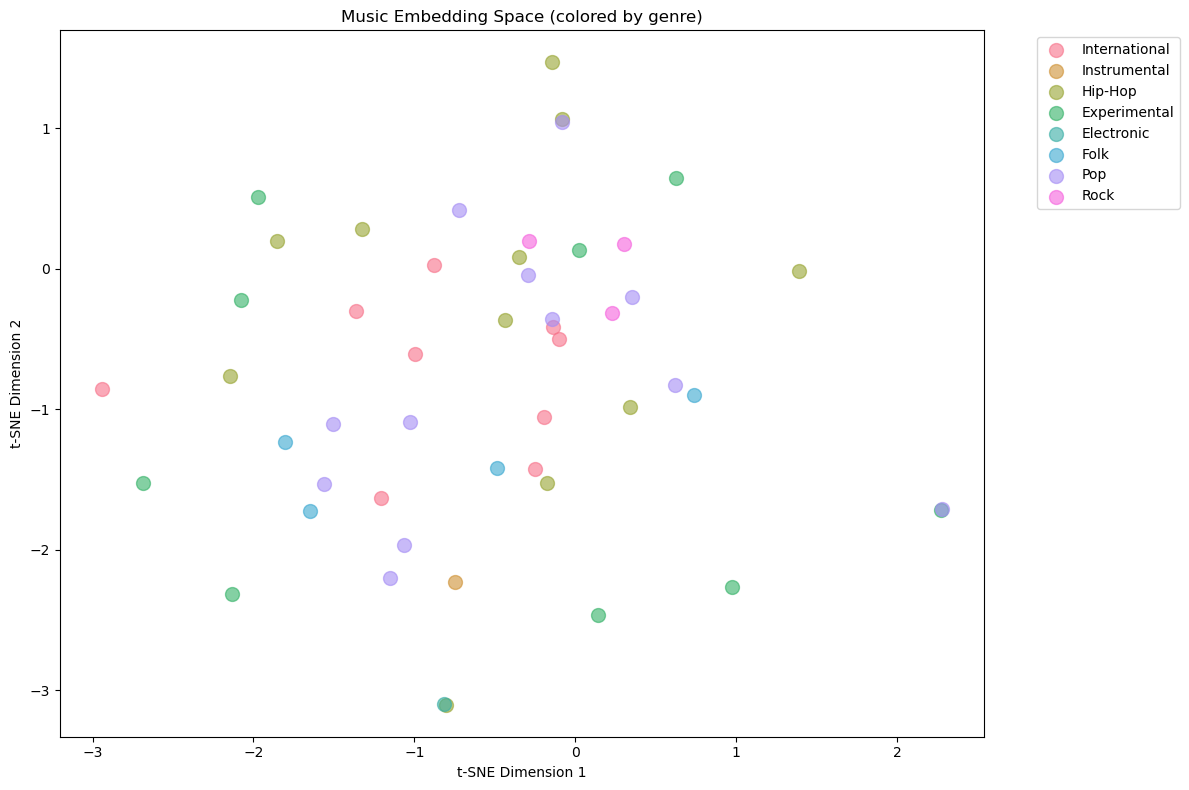

In [26]:
def visualize_embedding_space(embeddings, track_ids, metadata_df, n_samples=50):
    """Visualize the embedding space using t-SNE."""
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # FIX: Convert to numpy array
    track_ids = np.array(track_ids)
    
    # Sample if too many points
    if len(embeddings) > n_samples:
        indices = np.random.choice(len(embeddings), n_samples, replace=False)
        embs_sample = embeddings[indices]
        ids_sample = track_ids[indices]  # Now this works!
    else:
        embs_sample = embeddings
        ids_sample = track_ids
    
    # Reduce to 2D
    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42)
    embs_2d = tsne.fit_transform(embs_sample)
    
    # Get genres for coloring
    genres = [metadata_df[metadata_df['track_id'] == tid]['genre_top'].values[0] 
              if tid in metadata_df['track_id'].values else 'Unknown'
              for tid in ids_sample]
    
    # Plot
    plt.figure(figsize=(12, 8))
    
    # Get unique genres and colors
    unique_genres = list(set(genres))
    colors = sns.color_palette('husl', n_colors=len(unique_genres))
    genre_to_color = dict(zip(unique_genres, colors))
    
    for genre in unique_genres:
        mask = np.array([g == genre for g in genres])
        plt.scatter(embs_2d[mask, 0], embs_2d[mask, 1], 
                   c=[genre_to_color[genre]], label=genre, alpha=0.6, s=100)
    
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('Music Embedding Space (colored by genre)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Now call it
visualize_embedding_space(embeddings, emb_track_ids, master_data)

## Part 7: Mood and Activity-Based Filtering

In [27]:
class MoodRecommender:
    """Mood and activity-based music recommendation."""
    
    # Define mood/activity profiles
    PROFILES = {
        'workout': {
            'tempo_range': (120, 180),
            'energy_min': 0.6,
            'moods': {'aggressive': 0.3, 'happy': 0.2}
        },
        'study': {
            'tempo_range': (60, 100),
            'energy_max': 0.5,
            'moods': {'acoustic': 0.4, 'sad': -0.3}  # negative = avoid
        },
        'relax': {
            'tempo_range': (50, 90),
            'energy_max': 0.4,
            'moods': {'acoustic': 0.5, 'aggressive': -0.5}
        },
        'party': {
            'tempo_range': (110, 140),
            'energy_min': 0.7,
            'moods': {'happy': 0.4, 'danceability': 0.5}
        }
    }
    
    def __init__(self, similarity_engine, feature_df):
        self.engine = similarity_engine
        self.feature_df = feature_df.set_index('track_id')
    
    def recommend_by_mood(self, activity, k=10, seed_track_id=None):
        """
        Recommend tracks for a specific activity/mood.
        
        If seed_track_id is provided, find similar tracks that match the mood.
        Otherwise, find any tracks matching the mood profile.
        """
        if activity not in self.PROFILES:
            print(f"Unknown activity: {activity}")
            print(f"Available: {list(self.PROFILES.keys())}")
            return None
        
        profile = self.PROFILES[activity]
        
        # Start with all tracks or similar tracks
        if seed_track_id:
            # Get similar tracks first
            candidates_df = self.engine.find_similar(seed_track_id, k=k*3)
            candidate_ids = candidates_df['track_id'].values
        else:
            candidate_ids = self.engine.track_ids
        
        # Filter by mood profile
        filtered = []
        for track_id in candidate_ids:
            if track_id not in self.feature_df.index:
                continue
            
            features = self.feature_df.loc[track_id]
            score = 1.0
            
            # Check tempo
            if 'tempo_range' in profile and 'tempo' in features.index:
                tempo = features['tempo']
                if not (profile['tempo_range'][0] <= tempo <= profile['tempo_range'][1]):
                    score *= 0.3  # Heavy penalty but not elimination
            
            # Check energy (RMS)
            if 'energy_min' in profile and 'rms_mean' in features.index:
                if features['rms_mean'] < profile['energy_min']:
                    score *= 0.5
            
            if 'energy_max' in profile and 'rms_mean' in features.index:
                if features['rms_mean'] > profile['energy_max']:
                    score *= 0.5
            
            # Check mood preferences
            if 'moods' in profile:
                for mood, weight in profile['moods'].items():
                    mood_col = f'mood_{mood}' if not mood.startswith('mood_') else mood
                    if mood_col in features.index and pd.notna(features[mood_col]):
                        if weight > 0:
                            score *= (1 + weight * features[mood_col])
                        else:
                            score *= (1 - abs(weight) * features[mood_col])
            
            filtered.append({'track_id': track_id, 'mood_score': score})
        
        # Sort by score and return top k
        results_df = pd.DataFrame(filtered).sort_values('mood_score', ascending=False).head(k)
        
        return results_df

# Create mood recommender
mood_recommender = MoodRecommender(similarity_engine, audio_features)
print("✓ MoodRecommender created")

✓ MoodRecommender created


In [28]:
# Test mood-based recommendations
def test_mood_recommendation(activity):
    print(f"\n{'='*80}")
    print(f"RECOMMENDATIONS FOR: {activity.upper()}")
    print(f"{'='*80}\n")
    
    recommendations = mood_recommender.recommend_by_mood(activity, k=5)
    
    if recommendations is not None and len(recommendations) > 0:
        for idx, row in recommendations.iterrows():
            track_info = master_data[master_data['track_id'] == row['track_id']].iloc[0]
            print(f"{idx+1}. {track_info['artist']} - {track_info['title']}")
            print(f"   Genre: {track_info['genre_top']}")
            print(f"   Mood Score: {row['mood_score']:.3f}")
            print()
    else:
        print("No recommendations found for this mood.")

# Test different moods
test_mood_recommendation('workout')
test_mood_recommendation('relax')


RECOMMENDATIONS FOR: WORKOUT

323. Jarrod Fowler - Index
   Genre: Experimental
   Mood Score: 1.000

324. Jarrod Fowler - Different Strokes for Different Folks
   Genre: Experimental
   Mood Score: 1.000

404. Justice Yeldham - Track 01
   Genre: Experimental
   Mood Score: 1.000

326. Jarrod Fowler - Preface
   Genre: Experimental
   Mood Score: 1.000

1. AWOL - Food
   Genre: Hip-Hop
   Mood Score: 0.500


RECOMMENDATIONS FOR: RELAX

1000. Druzina - Pajdusko
   Genre: International
   Mood Score: 1.000

888. Hall Of Fame - part1
   Genre: Folk
   Mood Score: 1.000

777. Pre - Lampion
   Genre: Hip-Hop
   Mood Score: 1.000

776. Pre - Yesterday
   Genre: Hip-Hop
   Mood Score: 1.000

255. Peter Biedermann - Running
   Genre: Folk
   Mood Score: 1.000



## Part 8: Save and Export

In [29]:
def save_similarity_system():
    """Save all components of the similarity system."""
    print("Saving similarity system...")
    
    # Save FAISS index
    faiss.write_index(similarity_engine.index, str(Config.faiss_index))
    print(f"✓ FAISS index saved to {Config.faiss_index}")
    
    # Save track IDs
    np.save(Config.models_dir / "track_ids.npy", similarity_engine.track_ids)
    print(f"✓ Track IDs saved")
    
    # Save embeddings
    np.save(Config.models_dir / "embeddings.npy", similarity_engine.embeddings)
    print(f"✓ Embeddings saved")
    
    # Save features
    audio_features.to_parquet(Config.models_dir / "audio_features.parquet")
    print(f"✓ Audio features saved")
    
    # Save master data - convert Path objects to strings
    master_data_copy = master_data.copy()
    
    # Convert any Path columns to strings
    for col in master_data_copy.columns:
        if master_data_copy[col].dtype == 'object':
            # Check if first non-null value is a Path
            sample = master_data_copy[col].dropna().iloc[0] if len(master_data_copy[col].dropna()) > 0 else None
            if sample and isinstance(sample, Path):
                master_data_copy[col] = master_data_copy[col].astype(str)
    
    master_data_copy.to_parquet(Config.models_dir / "master_data.parquet")
    print(f"✓ Master data saved")
    
    print("\n✓✓✓ All components saved successfully!")

# Run it
save_similarity_system()

Saving similarity system...
✓ FAISS index saved to C:\Users\nakay\Documents\musicrec\data\models\similarity.index
✓ Track IDs saved
✓ Embeddings saved
✓ Audio features saved
✓ Master data saved

✓✓✓ All components saved successfully!


In [30]:
def load_similarity_system():
    """Load a previously saved similarity system."""
    print("Loading similarity system...")
    
    # Load data
    embeddings = np.load(Config.models_dir / "embeddings.npy")
    track_ids = np.load(Config.models_dir / "track_ids.npy")
    audio_features = pd.read_parquet(Config.models_dir / "audio_features.parquet")
    master_data = pd.read_parquet(Config.models_dir / "master_data.parquet")
    
    # Rebuild engine
    engine = HybridSimilarityEngine(
        embeddings=embeddings,
        track_ids=track_ids,
        feature_df=audio_features,
        metadata_df=master_data
    )
    
    print("✓ System loaded successfully!")
    return engine, master_data

# Example usage:
# reloaded_engine, reloaded_data = load_similarity_system()

## Part 9: Interactive Demo Interface

In [33]:
def interactive_demo():
    """Interactive demonstration of the recommendation system."""
    print("\n" + "="*80)
    print("MUSIC SIMILARITY & RECOMMENDATION SYSTEM")
    print("="*80)
    print("\nAvailable commands:")
    print("  1. Find similar songs to a track")
    print("  2. Find similar songs within a specific genre")  
    print("  3. Get mood-based recommendations")
    print("  4. Browse available tracks")
    print("  5. List available genres")  
    print("  6. Exit")
    print()
    
    while True:
        choice = input("Enter command (1-6): ").strip()
        
        if choice == '1':
            # Show some tracks
            print("\nSample tracks:")
            sample = master_data[master_data['track_id'].isin(emb_track_ids)].head(10)
            for idx, row in sample.iterrows():
                print(f"  {row['track_id']}: {row['artist']} - {row['title']} [{row['genre_top']}]")
            
            track_id = int(input("\nEnter track ID: "))
            k = int(input("How many recommendations? (default 5): ") or "5")
            
            results = similarity_engine.find_similar(track_id, k=k)
            if results is not None:
                display_recommendation(track_id, results, master_data)
        
        elif choice == '2': 
            # Show available genres
            genres = master_data[master_data['track_id'].isin(emb_track_ids)]['genre_top'].value_counts()
            print("\nAvailable genres:")
            for genre, count in genres.head(15).items():
                print(f"  {genre}: {count} tracks")
            
            # Show some tracks
            print("\nSample tracks:")
            sample = master_data[master_data['track_id'].isin(emb_track_ids)].head(10)
            for idx, row in sample.iterrows():
                print(f"  {row['track_id']}: {row['artist']} - {row['title']} [{row['genre_top']}]")
            
            track_id = int(input("\nEnter track ID: "))
            genre_choice = input("Enter genre (or press Enter to use track's genre): ").strip()
            k = int(input("How many recommendations? (default 5): ") or "5")
            
            genre = genre_choice if genre_choice else None
            results = similarity_engine.find_similar_in_genre(track_id, genre=genre, k=k)
            if results is not None:
                display_recommendation(track_id, results, master_data)
        
        elif choice == '3':
            print("\nAvailable moods:")
            for mood in MoodRecommender.PROFILES.keys():
                print(f"  - {mood}")
            
            mood = input("\nEnter mood/activity: ").strip().lower()
            test_mood_recommendation(mood)
        
        elif choice == '4':
            n = int(input("How many tracks to show? (default 20): ") or "20")
            print("\nAvailable tracks:")
            sample = master_data[master_data['track_id'].isin(emb_track_ids)].head(n)
            for idx, row in sample.iterrows():
                print(f"  {row['track_id']}: {row['artist']} - {row['title']} ({row['genre_top']})")
        
        elif choice == '5':  # NEW GENRE LIST
            print("\nGenre distribution in dataset:")
            genres = master_data[master_data['track_id'].isin(emb_track_ids)]['genre_top'].value_counts()
            for genre, count in genres.items():
                print(f"  {genre}: {count} tracks")
        
        elif choice == '6':
            print("\nThank you for using the Music Recommendation System!")
            break
        
        else:
            print("Invalid choice. Please try again.")
        
        print("\n" + "-"*80 + "\n")

# Run the demo
interactive_demo()



MUSIC SIMILARITY & RECOMMENDATION SYSTEM

Available commands:
  1. Find similar songs to a track
  2. Find similar songs within a specific genre
  3. Get mood-based recommendations
  4. Browse available tracks
  5. List available genres
  6. Exit



Enter command (1-6):  1



Sample tracks:
  2: AWOL - Food [Hip-Hop]
  5: AWOL - This World [Hip-Hop]
  10: Kurt Vile - Freeway [Pop]
  140: Alec K. Redfearn & the Eyesores - Queen Of The Wires [Folk]
  141: Alec K. Redfearn & the Eyesores - Ohio [Folk]
  148: Contradiction - Blackout 2 [Experimental]
  182: Ariel Pink's Haunted Graffiti - Jules Lost His Jewels [Rock]
  190: Ed Askew - Castle Of Stars [Folk]
  193: Ed Askew - Here With You [Folk]
  194: Ed Askew - All I want to Do [Folk]



Enter track ID:  5
How many recommendations? (default 5):  3


QUERY TRACK: AWOL - This World
Genre: Hip-Hop

SIMILAR TRACKS:

1. Talib Kweli - D'Evils 2008
   Genre: Hip-Hop
   Overall Similarity: 0.890
   ├─ Sound:    0.907
   ├─ Acoustic: 0.818
   └─ Genre:    1.000

2. Majik Most - Just a Feelin'
   Genre: Hip-Hop
   Overall Similarity: 0.874
   ├─ Sound:    0.899
   ├─ Acoustic: 0.781
   └─ Genre:    1.000

3. Majik Most - Deranged Barber
   Genre: Hip-Hop
   Overall Similarity: 0.868
   ├─ Sound:    0.893
   ├─ Acoustic: 0.775
   └─ Genre:    1.000


--------------------------------------------------------------------------------



Enter command (1-6):  1



Sample tracks:
  2: AWOL - Food [Hip-Hop]
  5: AWOL - This World [Hip-Hop]
  10: Kurt Vile - Freeway [Pop]
  140: Alec K. Redfearn & the Eyesores - Queen Of The Wires [Folk]
  141: Alec K. Redfearn & the Eyesores - Ohio [Folk]
  148: Contradiction - Blackout 2 [Experimental]
  182: Ariel Pink's Haunted Graffiti - Jules Lost His Jewels [Rock]
  190: Ed Askew - Castle Of Stars [Folk]
  193: Ed Askew - Here With You [Folk]
  194: Ed Askew - All I want to Do [Folk]



Enter track ID:  10
How many recommendations? (default 5):  3


QUERY TRACK: Kurt Vile - Freeway
Genre: Pop

SIMILAR TRACKS:

1. Half Japanese - No Big Deal
   Genre: Rock
   Overall Similarity: 0.790
   ├─ Sound:    0.912
   ├─ Acoustic: 0.808
   └─ Genre:    0.000

2. New Bomb Turks - So Long, Silver Lining
   Genre: Rock
   Overall Similarity: 0.761
   ├─ Sound:    0.911
   ├─ Acoustic: 0.716
   └─ Genre:    0.000

3. Magic Lantern - Feasting on Energy
   Genre: Experimental
   Overall Similarity: 0.723
   ├─ Sound:    0.921
   ├─ Acoustic: 0.566
   └─ Genre:    0.000


--------------------------------------------------------------------------------



Enter command (1-6):  2



Available genres:
  Folk: 199 tracks
  International: 190 tracks
  Hip-Hop: 152 tracks
  Rock: 132 tracks
  Pop: 124 tracks
  Experimental: 124 tracks
  Electronic: 48 tracks
  Instrumental: 31 tracks

Sample tracks:
  2: AWOL - Food [Hip-Hop]
  5: AWOL - This World [Hip-Hop]
  10: Kurt Vile - Freeway [Pop]
  140: Alec K. Redfearn & the Eyesores - Queen Of The Wires [Folk]
  141: Alec K. Redfearn & the Eyesores - Ohio [Folk]
  148: Contradiction - Blackout 2 [Experimental]
  182: Ariel Pink's Haunted Graffiti - Jules Lost His Jewels [Rock]
  190: Ed Askew - Castle Of Stars [Folk]
  193: Ed Askew - Here With You [Folk]
  194: Ed Askew - All I want to Do [Folk]



Enter track ID:  194
Enter genre (or press Enter to use track's genre):  5
How many recommendations? (default 5):  3


No tracks found in genre: 5

--------------------------------------------------------------------------------



Enter command (1-6):  2



Available genres:
  Folk: 199 tracks
  International: 190 tracks
  Hip-Hop: 152 tracks
  Rock: 132 tracks
  Pop: 124 tracks
  Experimental: 124 tracks
  Electronic: 48 tracks
  Instrumental: 31 tracks

Sample tracks:
  2: AWOL - Food [Hip-Hop]
  5: AWOL - This World [Hip-Hop]
  10: Kurt Vile - Freeway [Pop]
  140: Alec K. Redfearn & the Eyesores - Queen Of The Wires [Folk]
  141: Alec K. Redfearn & the Eyesores - Ohio [Folk]
  148: Contradiction - Blackout 2 [Experimental]
  182: Ariel Pink's Haunted Graffiti - Jules Lost His Jewels [Rock]
  190: Ed Askew - Castle Of Stars [Folk]
  193: Ed Askew - Here With You [Folk]
  194: Ed Askew - All I want to Do [Folk]



Enter track ID:  194
Enter genre (or press Enter to use track's genre):  International
How many recommendations? (default 5):  4


Searching within 190 tracks in 'International' genre
QUERY TRACK: Ed Askew - All I want to Do
Genre: Folk

SIMILAR TRACKS:

1. Salam - Drogue
   Genre: International
   Overall Similarity: 0.803
   ├─ Sound:    0.898
   ├─ Acoustic: 0.547
   └─ Genre:    1.000

2. Salam - Tara
   Genre: International
   Overall Similarity: 0.763
   ├─ Sound:    0.911
   ├─ Acoustic: 0.390
   └─ Genre:    1.000

3. Cuban Cowboys - Sr. Balaban
   Genre: International
   Overall Similarity: 0.743
   ├─ Sound:    0.885
   ├─ Acoustic: 0.372
   └─ Genre:    1.000

4. Conjunto Guantanamo - Title Unknown
   Genre: International
   Overall Similarity: 0.726
   ├─ Sound:    0.881
   ├─ Acoustic: 0.324
   └─ Genre:    1.000


--------------------------------------------------------------------------------



Enter command (1-6):  3



Available moods:
  - workout
  - study
  - relax
  - party



Enter mood/activity:  study



RECOMMENDATIONS FOR: STUDY

1000. Druzina - Pajdusko
   Genre: International
   Mood Score: 1.000

376. Boss Hog - Saved
   Genre: Rock
   Mood Score: 1.000

371. Mia Doi Todd - Deep At Sea
   Genre: Folk
   Mood Score: 1.000

727. Throwing Muses - Say Goodbye
   Genre: Rock
   Mood Score: 1.000

369. Z'EV - First Movement
   Genre: Experimental
   Mood Score: 1.000


--------------------------------------------------------------------------------



Enter command (1-6):  6



Thank you for using the Music Recommendation System!


In [32]:
# TEST CELL: Quick test of genre search functionality
print("Testing genre-specific search...\n")

# Pick a test track
if len(emb_track_ids) > 5:
    test_track = emb_track_ids[5]
    test_info = master_data[master_data['track_id'] == test_track].iloc[0]
    
    print(f"Test Track: {test_info['artist']} - {test_info['title']}")
    print(f"Genre: {test_info['genre_top']}\n")
    
    # Find similar tracks in same genre
    print("Finding similar tracks in same genre...")
    results = similarity_engine.find_similar_in_genre(test_track, k=5)
    
    if results is not None:
        print("\nResults:")
        for idx, row in results.iterrows():
            track_info = master_data[master_data['track_id'] == row['track_id']].iloc[0]
            print(f"  {idx+1}. {track_info['artist']} - {track_info['title']}")
            print(f"     Genre: {track_info['genre_top']} | Similarity: {row['similarity']:.3f}")
    
    print("\n✓ Genre search working!")
else:
    print("Not enough tracks to test. Please run feature extraction first.")


Testing genre-specific search...

Test Track: Contradiction - Blackout 2
Genre: Experimental

Finding similar tracks in same genre...
Searching within 124 tracks in 'Experimental' genre

Results:
  1. Funky Terrorist - Paku Paku
     Genre: Experimental | Similarity: 0.750
  2. Free Matter for the Blind - Outside of fashion boutique, Xian, China
     Genre: Experimental | Similarity: 0.667
  3. Lucky Dragons - leaving things as they are
     Genre: Experimental | Similarity: 0.660
  4. Negativland - No Business
     Genre: Experimental | Similarity: 0.586
  5. Lucky Dragons - Onda Tocadisco
     Genre: Experimental | Similarity: 0.581

✓ Genre search working!
